<a href="https://colab.research.google.com/github/prasiddha42o/mlpc/blob/main/MLPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#Importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, year
from joblib import Parallel, delayed
import time

In [2]:
df = pd.read_csv('/content/Forest-Fire.csv', dtype={'version': str})

In [3]:
df.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,36.8527,35.3594,306.0,2.1,1.4,2000-11-01,815,Terra,MODIS,60,6.03,294.4,13.2,D,0
1,40.5441,35.1786,307.8,1.1,1.0,2000-11-02,857,Terra,MODIS,66,6.03,296.0,5.8,D,0
2,40.1473,35.0444,305.3,1.1,1.0,2000-11-02,857,Terra,MODIS,46,6.03,293.5,4.3,D,0
3,40.5421,35.1909,310.0,1.1,1.0,2000-11-02,857,Terra,MODIS,69,6.03,296.1,7.3,D,0
4,41.2569,31.4172,307.9,1.1,1.0,2000-11-02,857,Terra,MODIS,0,6.03,290.4,8.0,D,2


In [5]:
#Checking data info for checking null values and datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39999 entries, 0 to 39998
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    39999 non-null  float64
 1   longitude   39999 non-null  float64
 2   brightness  39999 non-null  float64
 3   scan        39999 non-null  float64
 4   track       39999 non-null  float64
 5   acq_date    39999 non-null  object 
 6   acq_time    39999 non-null  int64  
 7   satellite   39999 non-null  object 
 8   instrument  39999 non-null  object 
 9   confidence  39999 non-null  int64  
 10  version     39999 non-null  object 
 11  bright_t31  39999 non-null  float64
 12  frp         39999 non-null  float64
 13  daynight    39999 non-null  object 
 14  type        39999 non-null  int64  
dtypes: float64(7), int64(3), object(5)
memory usage: 4.6+ MB


In [9]:
#Converting date and time columns to proper formtting using to_datetime function from pandas
df['acq_date'] = pd.to_datetime(df['acq_date'])
df['acq_time'] = df['acq_time'].astype(str).str.zfill(4)
#Ensuring 4 digit format
df['acq_hour'] = pd.to_datetime(df['acq_time'], format='%H%M').dt.hour

#Label encoding categorical columns: 'daynight', 'satellite', 'instrument'
label_encoders = {}
categorical_cols = ['daynight', 'satellite', 'instrument']
for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

#Extracting more features for time
df['year'] = df['acq_date'].dt.year
df['month'] = df['acq_date'].dt.month
df['day'] = df['acq_date'].dt.day
df['weekday'] = df['acq_date'].dt.weekday

#Dropping duplicates values
df = df.drop_duplicates()

#Handling missing values
df = df.dropna()

In [10]:
#Checking columns
df.columns

Index(['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date',
       'acq_time', 'satellite', 'instrument', 'confidence', 'version',
       'bright_t31', 'frp', 'daynight', 'type', 'acq_hour', 'daynight_encoded',
       'satellite_encoded', 'instrument_encoded', 'year', 'month', 'day',
       'weekday'],
      dtype='object')

In [ ]:
#Viewing top 5 rows of dataset
df.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,...,daynight,type,acq_hour,daynight_encoded,satellite_encoded,instrument_encoded,year,month,day,weekday
0,36.8527,35.3594,306.0,2.1,1.4,2000-11-01,0815,Terra,MODIS,60,...,D,0.0,8,0,1,0,2000,11,1,2
1,40.5441,35.1786,307.8,1.1,1.0,2000-11-02,0857,Terra,MODIS,66,...,D,0.0,8,0,1,0,2000,11,2,3
2,40.1473,35.0444,305.3,1.1,1.0,2000-11-02,0857,Terra,MODIS,46,...,D,0.0,8,0,1,0,2000,11,2,3
3,40.5421,35.1909,310.0,1.1,1.0,2000-11-02,0857,Terra,MODIS,69,...,D,0.0,8,0,1,0,2000,11,2,3
6,39.1096,33.9391,324.5,1.0,1.0,2000-11-02,0858,Terra,MODIS,82,...,D,0.0,8,0,1,0,2000,11,2,3


/tmp/ipython-input-14-4192881809.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='year', y='frp', data=df, estimator='mean', ci=None)


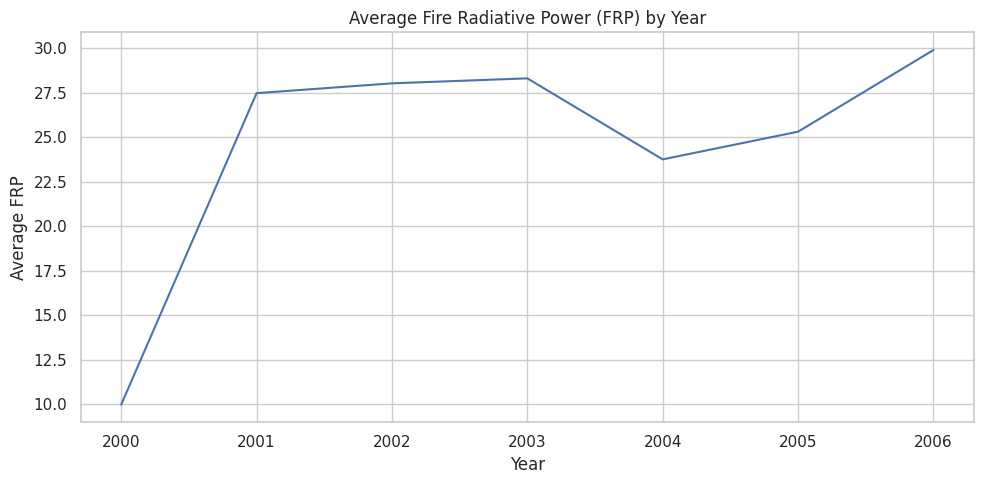

In [14]:
#Lineplot of Average Fire radiative power(FRP) by year
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.lineplot(x='year', y='frp', data=df, estimator='mean', ci=None)
plt.title('Average Fire Radiative Power (FRP) by Year')
plt.ylabel('Average FRP')
plt.xlabel('Year')
plt.tight_layout()
plt.grid(True)
plt.show()

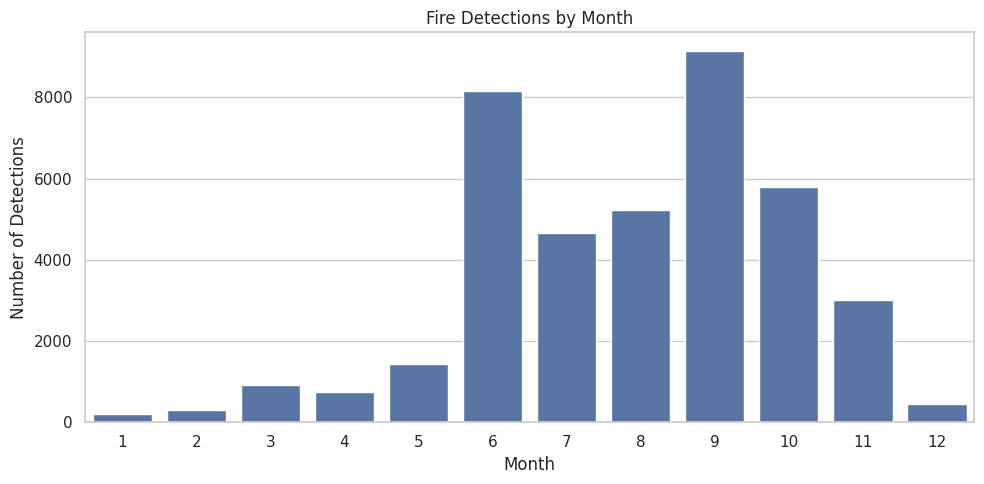

In [15]:
#Countplot Fire Detections by Month
plt.figure(figsize=(10, 5))
sns.countplot(x='month', data=df)
plt.title('Fire Detections by Month')
plt.xlabel('Month')
plt.ylabel('Number of Detections')
plt.tight_layout()
plt.show()

In [16]:
#Removing outliers using Interquartile Range(IQR)
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

#Calculating Q1 and Q3 for numerical columns
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

#Defining upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Filtering out outliers from the dataset
filtered_data = df[~((df[numerical_cols] < lower_bound) | (df[numerical_cols] > upper_bound)).any(axis=1)]

print(f"Original data shape: {df.shape}")
print(f"Filtered data shape: {filtered_data.shape}")

df = filtered_data.copy()

Original data shape: (39999, 23)
Filtered data shape: (25756, 23)


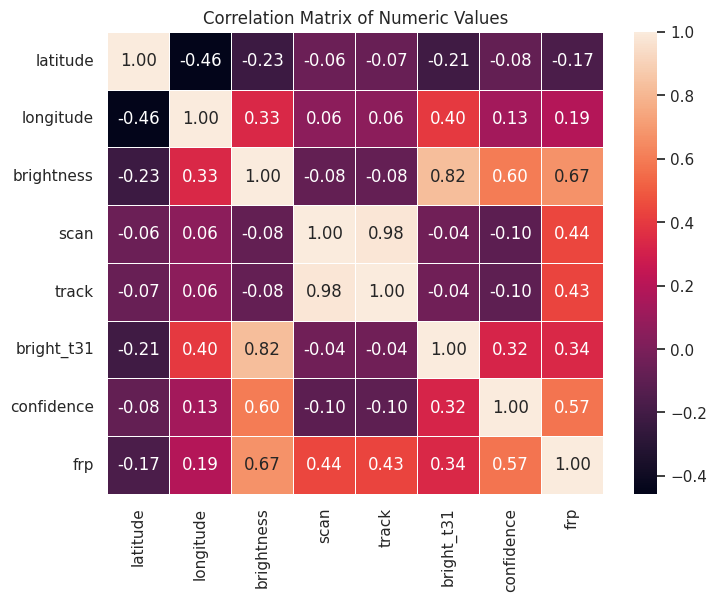

In [59]:
#Visualizing correlation matrix
numeric_df= df[['latitude', 'longitude', 'brightness', 'scan', 'track', 'bright_t31', 'confidence', 'frp']].corr()

#Plotting heatmap
plt.figure(figsize=(8,6))
sns.heatmap(numeric_df, annot=True, cmap='rocket', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Values")
plt.show()

In [24]:
#Selecting features and target

#Features(Consists Numerical columns only)
features = [
    'brightness', 'scan', 'track', 'confidence', 'bright_t31',
    'latitude', 'longitude', 'acq_hour', 'month', 'weekday',
    'daynight_encoded', 'satellite_encoded', 'instrument_encoded'
]
target = 'frp'

X = df[features]
y = df[target]


In [25]:
#Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
#Training Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)

#Predicting on test data
y_pred_lr = lr.predict(X_test)

#Evaluating Linear Regression according to performance metrics
print("Linear Regression Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R2 Score:", r2_score(y_test, y_pred_lr))

Linear Regression Performance:
MAE: 3.1645697914288866
MSE: 17.727424411233873
RMSE: 4.210394804674958
R2 Score: 0.8791252806793239


In [28]:
#Training Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

#Predicting on test data
y_pred_rf = rf.predict(X_test)

#Evaluating Random Forest according to performance metrics
print("Random Forest Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2 Score:", r2_score(y_test, y_pred_rf))


Random Forest Performance:
MAE: 1.8454813664596272
MSE: 7.425435382763977
RMSE: 2.7249652076244897
R2 Score: 0.9493695532467403


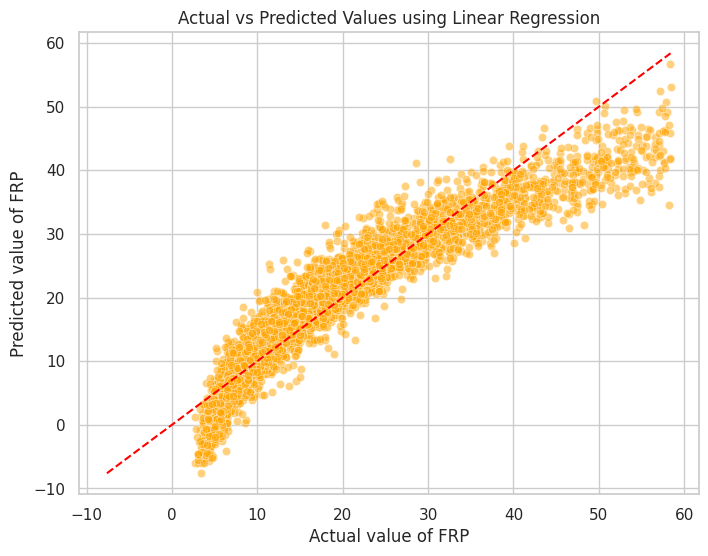

In [39]:
#Plotting Linear Regression Results
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.5, color="orange")
#Plotting perfect prediction line
min_val = min(y_test.min(), y_pred_lr.min())
max_val = max(y_test.max(), y_pred_lr.max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', label='Perfect Prediction Line')
plt.xlabel("Actual value of FRP")
plt.ylabel("Predicted value of FRP")
plt.title("Actual vs Predicted Values using Linear Regression")
plt.show()

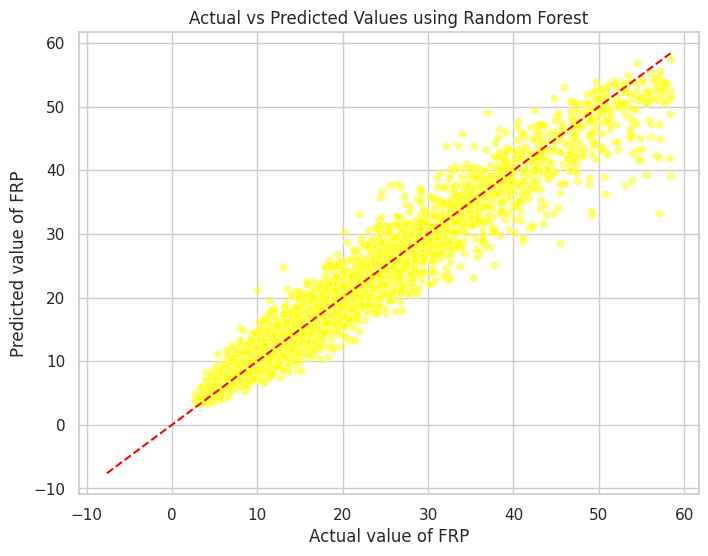

In [40]:
#Plotting Random Forest Results
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5, color="yellow")
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', label='Perfect Prediction Line')
plt.xlabel("Actual value of FRP")
plt.ylabel("Predicted value of FRP")
plt.title("Actual vs Predicted Values using Random Forest")
plt.show()

In [44]:
#Creating Spark session
spark = SparkSession.builder.appName("ForestFireAnalysis").getOrCreate()

#Creating dataframe in spark
spark_df= spark.createDataFrame(df)
spark_df.show()

+--------+---------+----------+----+-----+-------------------+--------+---------+----------+----------+-------+----------+----+--------+----+--------+----------------+-----------------+------------------+----+-----+---+-------+
|latitude|longitude|brightness|scan|track|           acq_date|acq_time|satellite|instrument|confidence|version|bright_t31| frp|daynight|type|acq_hour|daynight_encoded|satellite_encoded|instrument_encoded|year|month|day|weekday|
+--------+---------+----------+----+-----+-------------------+--------+---------+----------+----------+-------+----------+----+--------+----+--------+----------------+-----------------+------------------+----+-----+---+-------+
| 36.8527|  35.3594|     306.0| 2.1|  1.4|2000-11-01 00:00:00|    0815|    Terra|     MODIS|        60|   6.03|     294.4|13.2|       D|   0|       8|               0|                1|                 0|2000|   11|  1|      2|
| 40.5441|  35.1786|     307.8| 1.1|  1.0|2000-11-02 00:00:00|    0857|    Terra|     MO

In [61]:
#Performing parallel aggregation'sum' in brightness column from our dataset
total_brightness = spark_df.agg(sum('brightness')).collect()[0][0]

print(f"Total Brightness: {total_brightness}")

Total Brightness: 8345063.999999993


In [62]:
#Extracting year from 'acq_date' and creating a new 'Year' column
spark_df_with_year = spark_df.withColumn("Year", year("acq_date"))

#Calculating sum of 'brightness' by year(by grouping by year)
final_result = spark_df_with_year.groupBy("Year").agg(sum("brightness").alias("total_brightness_by_year"))

#Showing the result
final_result.orderBy("Year").show()

+----+------------------------+
|Year|total_brightness_by_year|
+----+------------------------+
|2000|      143466.59999999998|
|2001|      1055280.4000000025|
|2002|       1449542.700000001|
|2003|       1583259.999999999|
|2004|      1801591.9000000013|
|2005|      1753257.8000000007|
|2006|                558664.6|
+----+------------------------+



In [63]:
#Linear Regression Training and Prediction using Joblib
print("Linear Regression Performance (Parallel):")
lr_parallel = LinearRegression()

lr_parallel.fit(X_train, y_train)

#parallel prediction
n_cores = -1
y_pred_lr_parallel = Parallel(n_jobs=n_cores)(delayed(lr_parallel.predict)(X_test.iloc[i:i+1]) for i in range(len(X_test)))
y_pred_lr_parallel = np.concatenate(y_pred_lr_parallel)


#Evaluating parallel Linear Regression
print("MAE:", mean_absolute_error(y_test, y_pred_lr_parallel))
print("MSE:", mean_squared_error(y_test, y_pred_lr_parallel))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr_parallel)))
print("R2 Score:", r2_score(y_test, y_pred_lr_parallel))

Linear Regression Performance (Parallel):
MAE: 3.1645697914288853
MSE: 17.727424411233873
RMSE: 4.210394804674958
R2 Score: 0.8791252806793239


In [50]:
#Random Forest Training and Prediction using Joblib
print("\nRandom Forest Performance (Parallel):")

rf_parallel = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=n_cores)
rf_parallel.fit(X_train, y_train)

#parallel prediction
y_pred_rf_parallel = rf_parallel.predict(X_test)

#Evaluating parallel Random Forest
print("MAE:", mean_absolute_error(y_test, y_pred_rf_parallel))
print("MSE:", mean_squared_error(y_test, y_pred_rf_parallel))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf_parallel)))
print("R2 Score:", r2_score(y_test, y_pred_rf_parallel))


Random Forest Performance (Parallel):
MAE: 1.8454813664596272
MSE: 7.425435382763979
RMSE: 2.7249652076244897
R2 Score: 0.9493695532467403


In [51]:
#Recording training time for Linear Regression
start_time = time.time()
lr = LinearRegression()
lr.fit(X_train, y_train)
end_time = time.time()
lr_train_time_sequential = end_time - start_time

#Recording training time for Random Forest
start_time = time.time()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
end_time = time.time()
rf_train_time_sequential = end_time - start_time

lr_train_time_parallel = lr_train_time_sequential

#Recording training time for Random Forest(parallel)
start_time = time.time()
rf_parallel = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=n_cores)
rf_parallel.fit(X_train, y_train)
end_time = time.time()
rf_train_time_parallel = end_time - start_time

#Printing the training times
print(f"Linear Regression Training Time (Sequential): {lr_train_time_sequential:.4f} seconds")
print(f"Linear Regression Training Time (Parallel): {lr_train_time_parallel:.4f} seconds")
print(f"Random Forest Training Time (Sequential): {rf_train_time_sequential:.4f} seconds")
print(f"Random Forest Training Time (Parallel): {rf_train_time_parallel:.4f} seconds")

Linear Regression Training Time (Sequential): 0.0125 seconds
Linear Regression Training Time (Parallel): 0.0125 seconds
Random Forest Training Time (Sequential): 17.3341 seconds
Random Forest Training Time (Parallel): 13.2969 seconds


In [52]:
#Calculating and printing accuracy metrics for sequential Linear Regression
print("Linear Regression Performance (Sequential):")
mae_lr_sequential = mean_absolute_error(y_test, y_pred_lr)
mse_lr_sequential = mean_squared_error(y_test, y_pred_lr)
rmse_lr_sequential = np.sqrt(mse_lr_sequential)
r2_lr_sequential = r2_score(y_test, y_pred_lr)
print("MAE:", mae_lr_sequential)
print("MSE:", mse_lr_sequential)
print("RMSE:", rmse_lr_sequential)
print("R2 Score:", r2_lr_sequential)

#Calculating and printing accuracy metrics for parallel Linear Regression
print("\nLinear Regression Performance (Parallel):")
mae_lr_parallel = mean_absolute_error(y_test, y_pred_lr_parallel)
mse_lr_parallel = mean_squared_error(y_test, y_pred_lr_parallel)
rmse_lr_parallel = np.sqrt(mse_lr_parallel)
r2_lr_parallel = r2_score(y_test, y_pred_lr_parallel)
print("MAE:", mae_lr_parallel)
print("MSE:", mse_lr_parallel)
print("RMSE:", rmse_lr_parallel)
print("R2 Score:", r2_lr_parallel)

#Calculating and printing accuracy metrics for sequential Random Forest
print("\nRandom Forest Performance (Sequential):")
mae_rf_sequential = mean_absolute_error(y_test, y_pred_rf)
mse_rf_sequential = mean_squared_error(y_test, y_pred_rf)
rmse_rf_sequential = np.sqrt(mse_rf_sequential)
r2_rf_sequential = r2_score(y_test, y_pred_rf)
print("MAE:", mae_rf_sequential)
print("MSE:", mse_rf_sequential)
print("RMSE:", rmse_rf_sequential)
print("R2 Score:", r2_rf_sequential)

#Calculating and printing accuracy metrics for parallel Random Forest
print("\nRandom Forest Performance (Parallel):")
mae_rf_parallel = mean_absolute_error(y_test, y_pred_rf_parallel)
mse_rf_parallel = mean_squared_error(y_test, y_pred_rf_parallel)
rmse_rf_parallel = np.sqrt(mse_rf_parallel)
r2_rf_parallel = r2_score(y_test, y_pred_rf_parallel)
print("MAE:", mae_rf_parallel)
print("MSE:", mse_rf_parallel)
print("RMSE:", rmse_rf_parallel)
print("R2 Score:", r2_rf_parallel)

Linear Regression Performance (Sequential):
MAE: 3.1645697914288866
MSE: 17.727424411233873
RMSE: 4.210394804674958
R2 Score: 0.8791252806793239

Linear Regression Performance (Parallel):
MAE: 3.1645697914288853
MSE: 17.727424411233873
RMSE: 4.210394804674958
R2 Score: 0.8791252806793239

Random Forest Performance (Sequential):
MAE: 1.8454813664596272
MSE: 7.425435382763977
RMSE: 2.7249652076244897
R2 Score: 0.9493695532467403

Random Forest Performance (Parallel):
MAE: 1.8454813664596272
MSE: 7.425435382763979
RMSE: 2.7249652076244897
R2 Score: 0.9493695532467403


In [53]:
#Creating a dictionary to store the results
results = {
    'Model': ['Linear Regression', 'Linear Regression', 'Random Forest', 'Random Forest'],
    'Processing': ['Sequential', 'Parallel', 'Sequential', 'Parallel'],
    'MAE': [mae_lr_sequential, mae_lr_parallel, mae_rf_sequential, mae_rf_parallel],
    'MSE': [mse_lr_sequential, mse_lr_parallel, mse_rf_sequential, mse_rf_parallel],
    'RMSE': [rmse_lr_sequential, rmse_lr_parallel, rmse_rf_sequential, rmse_rf_parallel],
    'R2 Score': [r2_lr_sequential, r2_lr_parallel, r2_rf_sequential, r2_rf_parallel],
    'Training Time (s)': [lr_train_time_sequential, lr_train_time_parallel, rf_train_time_sequential, rf_train_time_parallel]
}

#Creating a pandas DataFrame from the dictionary
results_df = pd.DataFrame(results)

#Displaying the DataFrame
display(results_df)

,Model,Processing,MAE,MSE,RMSE,R2 Score,Training Time (s)
0,Linear Regression,Sequential,3.164570,17.727424,4.210395,0.879125,0.012477
1,Linear Regression,Parallel,3.164570,17.727424,4.210395,0.879125,0.012477
2,Random Forest,Sequential,1.845481,7.425435,2.724965,0.949370,17.334063
3,Random Forest,Parallel,1.845481,7.425435,2.724965,0.949370,13.296889


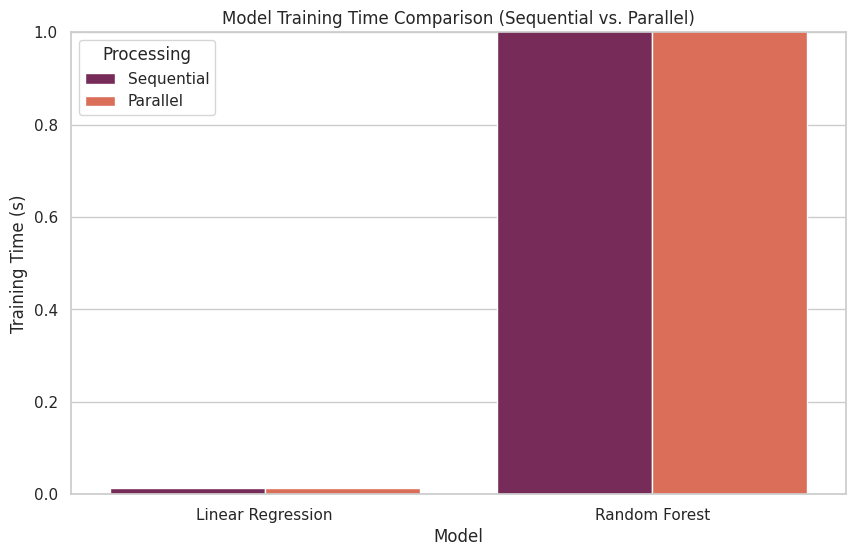

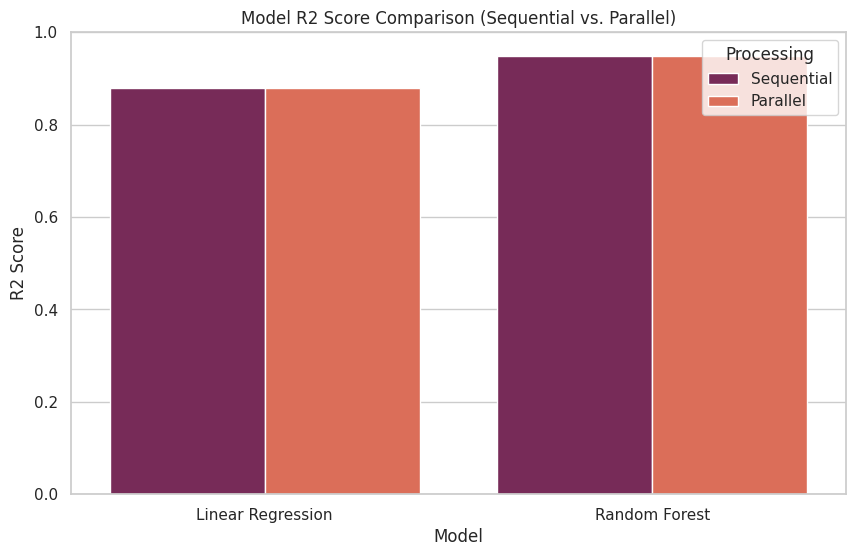

In [58]:
#Ploting Training Time Comparison between models
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Training Time (s)', hue='Processing', data=results_df, palette='rocket')
plt.title('Model Training Time Comparison (Sequential vs. Parallel)')
plt.ylabel('Training Time (s)')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.show()

#Plotting R2 Score Comparison between models
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R2 Score', hue='Processing', data=results_df, palette='rocket')
plt.title('Model R2 Score Comparison (Sequential vs. Parallel)')
plt.ylabel('R2 Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.show()

In [6]:
import psutil
import time
import matplotlib.pyplot as plt

def monitor_resource_usage(duration=15):
    cpu_usage = []
    memory_usage = []
    timestamps = []

    start_time = time.time()
    while (time.time() - start_time) < duration:
        cpu = psutil.cpu_percent(interval=1)
        memory = psutil.virtual_memory().percent
        timestamp = time.time() - start_time

        cpu_usage.append(cpu)
        memory_usage.append(memory)
        timestamps.append(timestamp)

    return timestamps, cpu_usage, memory_usage

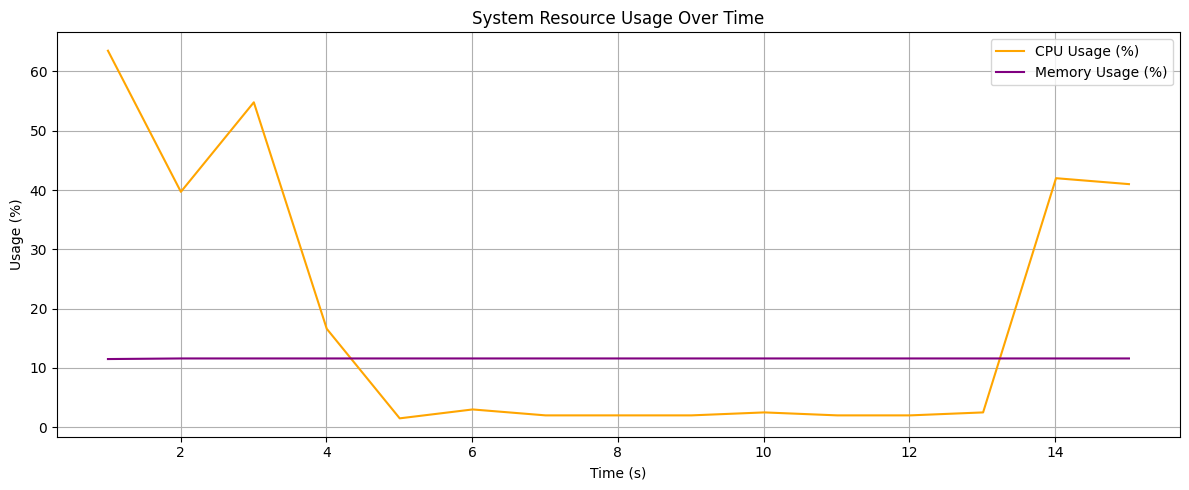

In [7]:
timestamps, cpu_usage, memory_usage = monitor_resource_usage(duration=15)

plt.figure(figsize=(12, 5))
plt.plot(timestamps, cpu_usage, label='CPU Usage (%)', color='orange')
plt.plot(timestamps, memory_usage, label='Memory Usage (%)', color='purple')
plt.xlabel('Time (s)')
plt.ylabel('Usage (%)')
plt.title('System Resource Usage Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()